In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

#Importando el model preentrenado MobileNetV2


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14548992/14536120 [==============================] - 0s 0us/step


## Función para preprocesar las imágenes para MobileNetV2

In [ ]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

# Graficando la imagen original

In [ ]:
image_path = tf.keras.utils.get_file('tortoise-ground-species-Galapagos-Islands-home-archipelago.jpg', 'https://i.ibb.co/hYqynKp/tortoise-ground-species-Galapagos-Islands-home-archipelago.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

237568/226895 [===============================] - 0s 1us/step


49152/35363 [=========================================] - 0s 0us/step


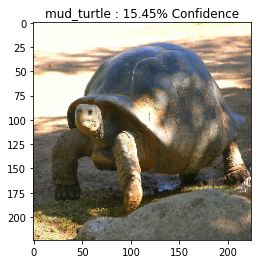

In [ ]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

#Creando el filtro para generar ejemplos adversarios

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad


## Visualizando el filtro

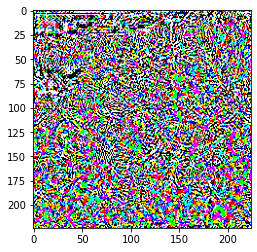

In [ ]:
# Get the input label of the image.
labrador_retriever_index = 208
max = tf.reduce_max(image_probs)
index = 0
for i in range(image_probs.shape[1]):
  if image_probs[0,i] == max:
    index = i
    break

    
label = tf.one_hot(index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

### Función para graficar las imágenes fácilmente

In [ ]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()
  return confidence

#Construyendo los ejemplos adversarios

###FSGM

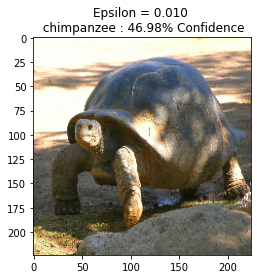

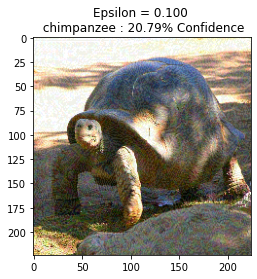

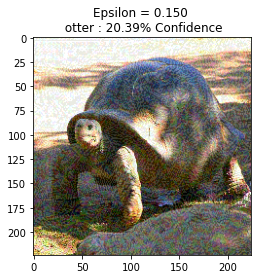

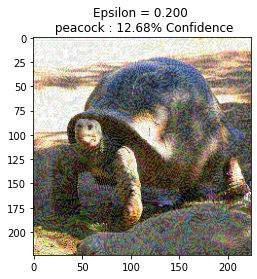

In [ ]:
epsilons = [0.01, 0.1, 0.15, 0.2]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]
perturbations = create_adversarial_pattern(image, label)
for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])


###PGD

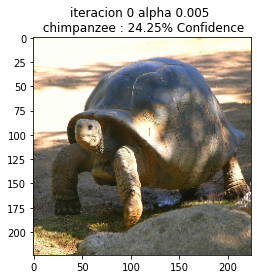

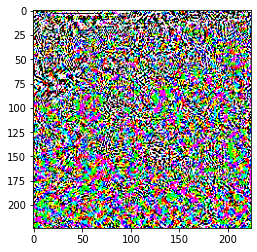

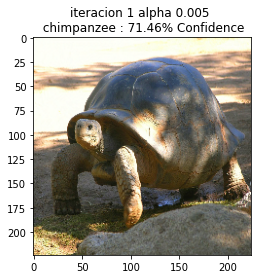

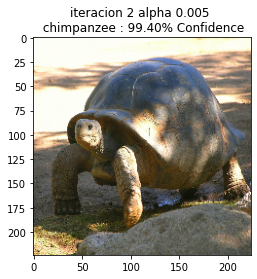

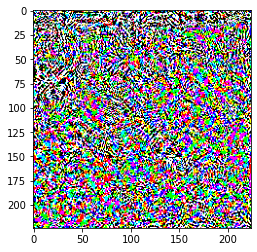

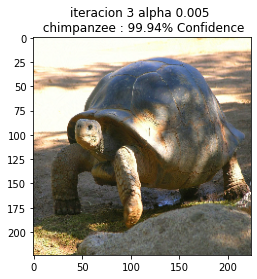

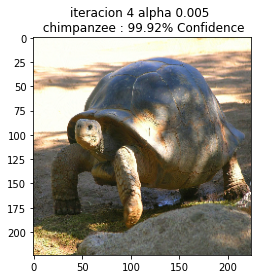

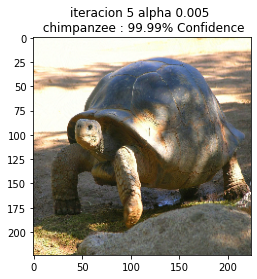

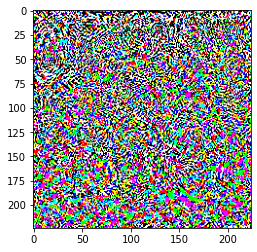

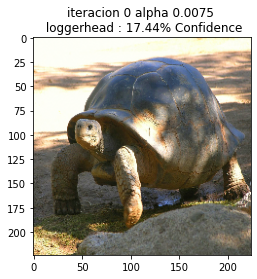

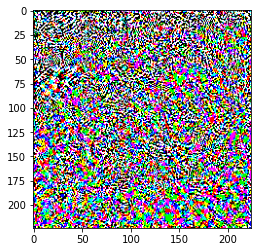

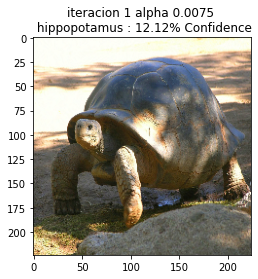

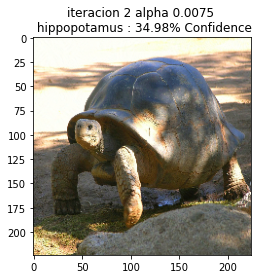

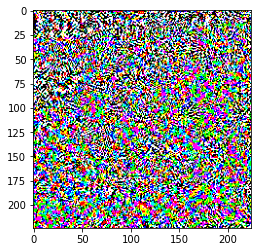

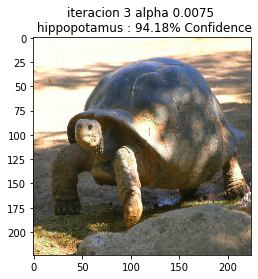

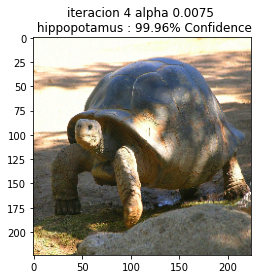

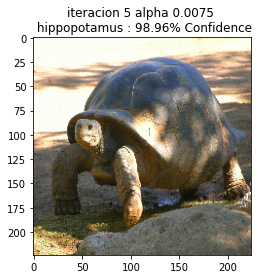

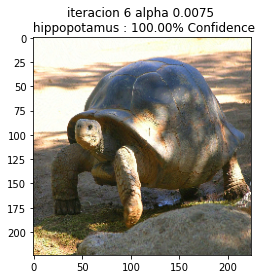

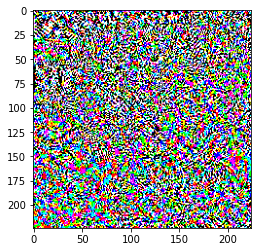

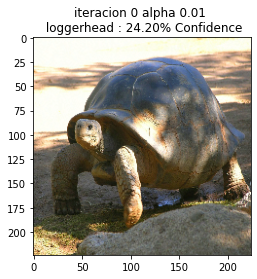

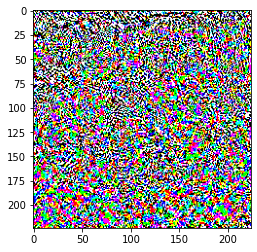

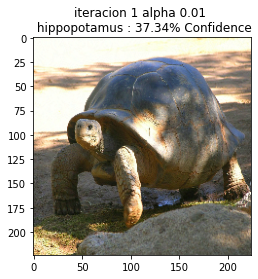

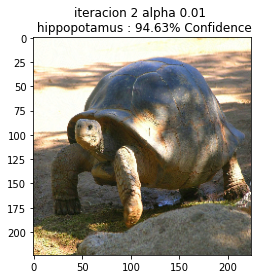

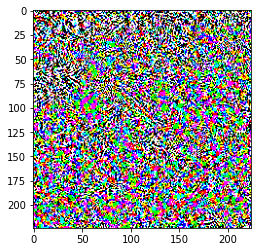

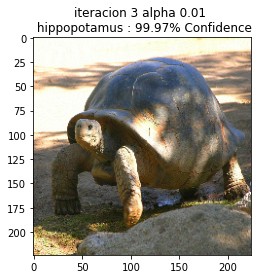

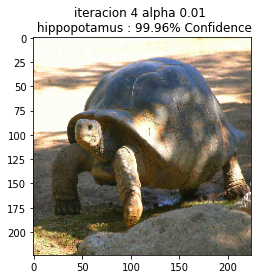

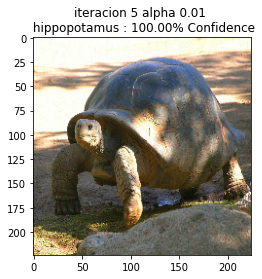

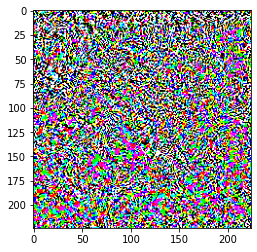

In [ ]:
iterations = 20
perturbations = create_adversarial_pattern(image, label)
for epsilon in epsilons:
  if epsilon == 0.01:
    continue
  alpha = epsilon/iterations
  adv_x = image + alpha * perturbations
  for i in range(iterations):
    img = tf.clip_by_value(adv_x, -1, 1)
    confidence = display_images(img, f'iteracion {i} alpha {alpha}')
    perturbations = create_adversarial_pattern(adv_x, label)
    if i == 2 or i == 0:
      plt.imshow(perturbations[0] * 0.5 + 0.5)
    if confidence >= 0.9999:
      plt.imshow(perturbations[0] * 0.5 + 0.5);
      break
    adv_x =  adv_x + alpha * perturbations

#Comparando tiempo de cómputo

###FSGM

In [ ]:
import time 
import numpy as np
perturbations = create_adversarial_pattern(image, label)

t_fsgm = []
t_0 = time.perf_counter()
for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  t_fsgm += [time.perf_counter()-t_0]

t_fsgm = np.array(t_fsgm)
print(f'Media de FSGM {t_fsgm.mean()} std {t_fsgm.std()}')

Media de FSGM 0.0005642957499958356 std 0.00021962398909191051


### PGD

In [ ]:
import time 
import numpy as np
t_pgd = {}
for epsilon in epsilons:
  t_0 = time.perf_counter()
  t = []
  alpha = epsilon/iterations
  adv_x = image + alpha * perturbations
  for i in range(iterations):
    perturbations = create_adversarial_pattern(adv_x, label)
    if i+1 == 3 or i+1 == 6: 
      t += [time.perf_counter() - t_0]
    adv_x =  adv_x + alpha * perturbations
  t_pgd[alpha] = np.array(t)


pgd_it_3 = []  
pgd_it_6 = [] 

alphas = []
for epsilon in epsilons:
  alphas += [epsilon /20]
  
for alpha in alphas:
  if alpha == alphas[0]:
    continue
  fgd_time_iteration = t_pgd[alpha]
  pgd_it_3 += [fgd_time_iteration[0]]
  pgd_it_6 += [fgd_time_iteration[1]]

pgd_it_3 = np.array(pgd_it_3)
pgd_it_6 = np.array(pgd_it_6)


print(f'PGD time iteration 3 mean {pgd_it_3.mean()}, std {pgd_it_3.std()}')
print(f'PGD time iteration 6 mean {pgd_it_6.mean()}, std {pgd_it_6.std()}')



PGD time iteration 3 mean 0.33980421633329644, std 0.007248285749825714
PGD time iteration 6 mean 0.696512054999971, std 0.010169975452869535


# Comparando efectividad de los métodos

###FGSM

In [ ]:
import numpy as np
confidence = []
correct_label = 'mud_turtle'
perturbations = create_adversarial_pattern(image, label)
for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  _, predicted_label, c = get_imagenet_label(pretrained_model.predict(adv_x))
  if predicted_label == correct_label:
    confidence += [-c]
  else:
    confidence += [c]

confidence = np.array(confidence)
print(f'Confidence FSGM mean {confidence.mean()}, std {confidence.std()}')

Confidence FSGM mean 0.27347037196159363, std 0.11336074024438858


### PGD

In [ ]:
import numpy as np
perturbations = create_adversarial_pattern(image, label)
real_label = 'mud_turtle'

t_pgd = {}
t_0 = time.perf_counter()

confidence_3 = []   
confidence_6 = []  


alphas = []
for epsilon in epsilons:
  alphas += [epsilon /20]

for alpha in alphas:
  if alpha == alphas[0]:
    continue
  adv_x = image + alpha * perturbations
  for i in range(iterations):
    perturbations = create_adversarial_pattern(adv_x, label)

    if i+1 == 3 or i+1 == 6: 
      t += [time.perf_counter() - t_0]
    _, predicted_label, c = get_imagenet_label(pretrained_model.predict(adv_x))

    if i+1 == 3: 
      if predicted_label == real_label:
        confidence_3 += [-c]
      else:
        confidence_3 += [c]

    if i+1 == 6: 
      if predicted_label == real_label:
        confidence_6 += [-c]
      else:
        confidence_6 += [c]
    adv_x =  adv_x + alpha * perturbations


confidence_3 = np.array(confidence_3)
confidence_6 = np.array(confidence_6)
print(f'confidence 3 mean {confidence_3.mean()} std {confidence_3.std()}')
print(f'confidence 6 mean {confidence_6.mean()} std {confidence_6.std()}')



confidence 3 mean 0.7336762547492981 std 0.35980454087257385
confidence 6 mean 0.9998494982719421 std 0.000147493279655464


#Referencias
Para la realización del código se tomó en base el mostrado en https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/adversarial_fgsm.ipynb , en donde se muestra cómo implementar un filtro FSGM. 